# Environment Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
from dataclasses import dataclass

import stim
from pymatching import Matching

from qutip import *

# Stim Study

Stim is a tool for high performance simulation and analysis of quantum stabilizer circuits, especially quantum error correction (QEC) circuits.

Stim's Key Features

1. Really fast simulation of stabilizer circuits. stim.Circuit.compile_sampler() performs a few seconds of analysis and then produce an object that can sample shots at kilohertz rates.

2. Semi-automatic decoder configuration. stim.Circuit.detector_error_model() converts a noisy circuit into a detector error model (a Tanner graph) which can be used to configure decoders. Adding the option decompose_operations=True will additionally suggest how hyper errors can be decomposed into graphlike errors, making it easier to configure matching-based decoders.

3. Useful building blocks for working with stabilizers, such as stim.PauliString, stim.Tableau, and stim.TableauSimulator.

Stim's main limitations

1. There is no support for non-Clifford operations, such as T gates and Toffoli gates. Only stabilizer operations are supported.

2. stim.Circuit only supports Pauli noise channels (eg. no amplitude decay). For more complex noise you must manually drive a stim.TableauSimulator.

3. stim.Circuit only supports single-control Pauli feedback. For multi-control feedback, or non-Pauli feedback, you must manually drive a stim.TableauSimulator.

Stim's main usage

Quantum Error Correction Code & Magic State Distillation simulation for $\text{Many}^{\text{Many}}$ qubits

Stim's computing power is too much for simulating distance-2,3 surface codes

In [ ]:
c = stim
dir(c)

['Circuit',
 'CircuitErrorLocation',
 'CircuitErrorLocationStackFrame',
 'CircuitInstruction',
 'CircuitRepeatBlock',
 'CircuitTargetsInsideInstruction',
 'CompiledDemSampler',
 'CompiledDetectorSampler',
 'CompiledMeasurementSampler',
 'CompiledMeasurementsToDetectionEventsConverter',
 'DemInstruction',
 'DemRepeatBlock',
 'DemTarget',
 'DemTargetWithCoords',
 'DetectorErrorModel',
 'ExplainedError',
 'FlipSimulator',
 'FlippedMeasurement',
 'Flow',
 'GateData',
 'GateTarget',
 'GateTargetWithCoords',
 'PauliString',
 'PauliStringIterator',
 'Tableau',
 'TableauIterator',
 'TableauSimulator',
 '_UNSTABLE_raw_format_data',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_detect_machine_architecture',
 '_stim_sse2',
 'gate_data',
 'main',
 'read_shot_data_file',
 'target_combined_paulis',
 'target_combiner',
 'target_inv',
 'target_logical_observable_id',
 'target_pauli',
 'target_rec',
 'ta

In [ ]:
import stim

# 1. Tableau 시뮬레이터 생성
sim = stim.TableauSimulator()

# 2. Bell state 생성: H(0) → CNOT(0,1)
sim.h(0)
sim.cx(0, 1)

# 3. 현재 상태의 stabilizer tableau 출력
print(sim.current_inverse_tableau())

# 4. Stabilizer generator를 명시적으로 출력
print("\nStabilizer generators:")
for s in sim.current_inverse_tableau().to_stabilizers():
    print(s)


+-xz-xz-
| ++ ++
| ZX _X
| X_ XZ

Stabilizer generators:
+X_
+XZ


## stim.Circuit

In [ ]:
c = stim.Circuit
dir(c)

['__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_pybind11_conduit_v1_',
 'append',
 'append_from_stim_program_text',
 'append_operation',
 'approx_equals',
 'clear',
 'compile_detector_sampler',
 'compile_m2d_converter',
 'compile_sampler',
 'copy',
 'count_determined_measurements',
 'decomposed',
 'detecting_regions',
 'detector_error_model',
 'diagram',
 'explain_detector_error_model_errors',
 'flattened',
 'flattened_operations',
 'flow_generators',
 'from_file',
 'generated',
 'get_detector_coordinates',
 'get_final_qubit_coordinates',
 'has_all_flows',
 'has_flow',
 'i

In [7]:
# 빈 회로 생성
c = stim.Circuit()

# 게이트 추가
c.append_operation("H", [0])             # Hadamard on qubit 0
c.append_operation("CNOT", [0, 1])       # CNOT(0→1)
c.append_operation("M", [0, 1])          # 두 큐비트를 측정
c.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-1)])  # 논리관측량

# 회로 출력
print(c)

H 0
CX 0 1
M 0 1
OBSERVABLE_INCLUDE(0) rec[-1]


In [ ]:
circuit = stim.Circuit("""
  QUBIT_COORDS(0, 0) 0
  QUBIT_COORDS(0, 1) 1
  H 0
  CNOT 0 1
  M 0 1
""")
print(circuit.diagram())

q0: -QUBIT_COORDS(0,0)-H-@-M:rec[0]-
                         |
q1: -QUBIT_COORDS(0,1)---X-M:rec[1]-


# 1Q Depolarizing Channel Sampling


$
\mathcal{E}_p(\rho)
= (1 - p)\rho + \frac{p}{3}\big(X\rho X + Y\rho Y + Z\rho Z\big)
$

$
\mathcal{E}_p(\rho)
= \frac{1}{2}\Big(I + \big(1 - \tfrac{4p}{3}\big)\,\vec{r}\cdot\vec{\sigma}\Big)
$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim

# ---- Helper functions ----
def build_tomo_circuit(p: float, basis: str) -> stim.Circuit:
    """
    회로: |0> 준비 -> H -> DEPOLARIZE1(p) -> (기저변환) -> M
    basis in {'X','Y','Z'}.
    """
    c = stim.Circuit()
    q = 0

    # 초기화 및 H
    c.append_operation("R", [q])
    c.append_operation("H", [q])

    # 1Q depolarizing (X/Y/Z 각각 p/3로 발생)
    c.append_operation("DEPOLARIZE1", [q], p)

    # 기저 회전 후 Z-측정으로 환원
    b = basis.upper()
    if b == "X":
        c.append_operation("H", [q])            # H Z H = X
    elif b == "Y":
        c.append_operation("S_DAG", [q])        # S† H Z H S = Y
        c.append_operation("H", [q])

    # 측정
    c.append_operation("M", [q])
    return c

def estimate_expectation_from_bits(bits: np.ndarray) -> float:
    """
    Stim의 M 결과는 {0,1}; 0 -> +1, 1 -> -1.
    <O> = 1 - 2*mean(bit)
    """
    return 1.0 - 2.0 * bits.mean()

def counts_of(bits: np.ndarray):
    vals, cnts = np.unique(bits, return_counts=True)
    d = {int(v): int(c) for v, c in zip(vals, cnts)}
    d.setdefault(0, 0); d.setdefault(1, 0)
    return d[0], d[1]

Imports/defs OK


In [ ]:
# 노이즈와 샷 수
p = 0.05       # depolarizing probability
shots = 1000000 # 샘플 수 (필요시 늘리면 통계 오차 감소)
bases = ["X", "Y", "Z"]
bases

['X', 'Y', 'Z']

counts: 0 -> 966794, 1 -> 33206 (total 1000000)


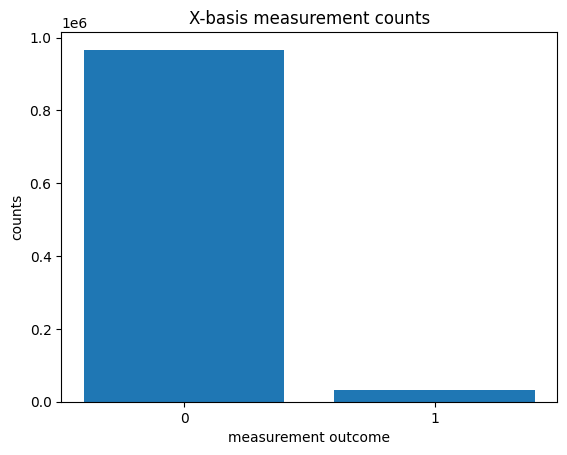

counts: 0 -> 499675, 1 -> 500325 (total 1000000)


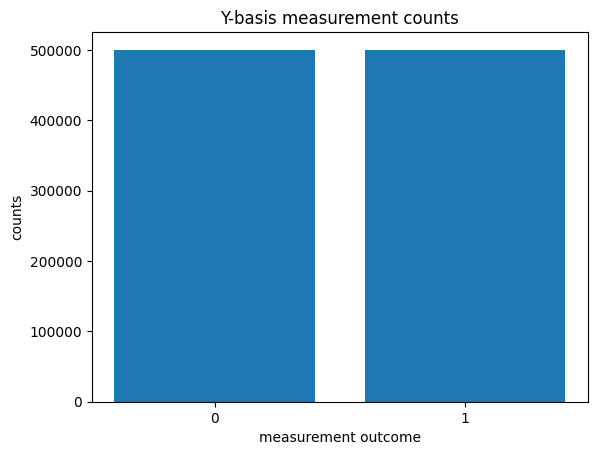

counts: 0 -> 499876, 1 -> 500124 (total 1000000)


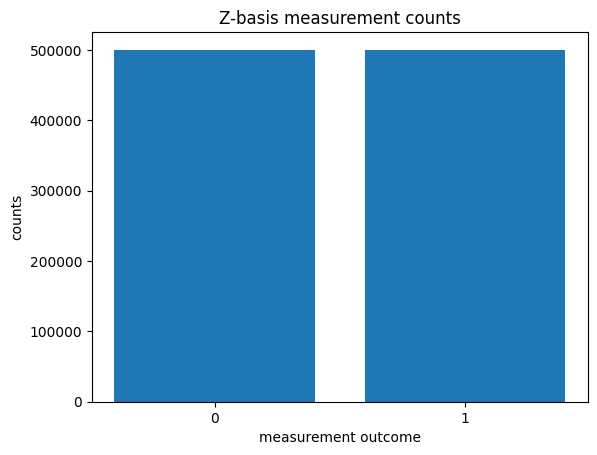


Sampling done.


In [ ]:
results = {}
for b in bases:
    c = build_tomo_circuit(p, b)
    sampler = c.compile_sampler()
    samples = sampler.sample(shots)  # shape: (shots, 1)
    bits = samples[:, 0]
    results[b] = bits

    # --- 카운트 ---
    c0, c1 = counts_of(bits)
    print(f"counts: 0 -> {c0}, 1 -> {c1} (total {shots})")

    # --- 히스토그램 (단일 플롯, 색상 지정 금지) ---
    fig = plt.figure()
    plt.bar([0,1], [c0, c1])
    plt.xticks([0,1], ["0", "1"])
    plt.xlabel("measurement outcome")
    plt.ylabel("counts")
    plt.title(f"{b}-basis measurement counts")
    plt.show()

print("\nSampling done.")


In [ ]:
exps = {b: (1.0 - 2.0 * results[b].mean()) for b in bases}  # <O> = 1 - 2*P(1)
rx, ry, rz = exps["X"], exps["Y"], exps["Z"]

I = np.eye(2, dtype=complex)
X = np.array([[0, 1],[1, 0]], dtype=complex)
Y = np.array([[0,-1j],[1j, 0]], dtype=complex)
Z = np.array([[1, 0],[0,-1 ]], dtype=complex)
rho = 0.5 * (I + rx*X + ry*Y + rz*Z)

print("<X>, <Y>, <Z> =", exps)
print("Bloch vector r =", (rx, ry, rz))
print("\nReconstructed density matrix ρ:")
np.set_printoptions(precision=4, suppress=True)
print(rho)

<X>, <Y>, <Z> = {'X': np.float64(0.933588), 'Y': np.float64(-0.0006500000000000394), 'Z': np.float64(-0.000248000000000026)}
Bloch vector r = (np.float64(0.933588), np.float64(-0.0006500000000000394), np.float64(-0.000248000000000026))

Reconstructed density matrix ρ:
[[0.4999+0.j     0.4668+0.0003j]
 [0.4668-0.0003j 0.5001+0.j    ]]


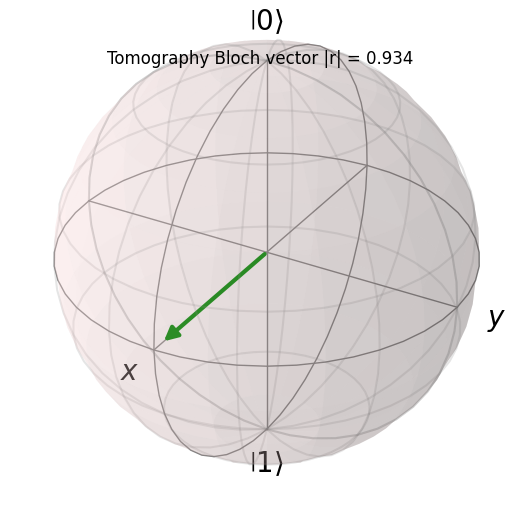

In [ ]:
b = Bloch()                  # Bloch sphere 객체
b.add_vectors([rx, ry, rz])     # 혼합상태면 화살표 길이가 1보다 짧음 (|r|<=1)
b.vector_color = [None]         # 색상은 기본값(설정 안 함)
b.point_color  = [None]
b.make_sphere()

b.fig.suptitle(f"Tomography Bloch vector |r| = {np.linalg.norm([rx,ry,rz]):.3f}", y=0.92)
b.show()

# 2Q Depolarizing Channel Sampling

Counts: {'++': 486650, '+-': 13344, '-+': 13432, '--': 486574}
<X⊗X> ≈ 0.94645


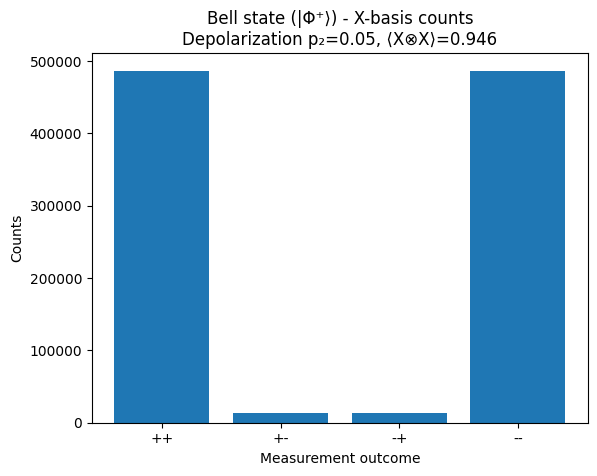

In [ ]:
import numpy as np
import stim

def build_bell_xx_circuit(p2: float) -> stim.Circuit:
    """
    |00> --H(q0)--> CX(q0->q1)  => |Phi+>
          --DEPOLARIZE2(p2)-->
          --H on both (X-basis rotate)--> M(q0,q1)
    """
    q0, q1 = 0, 1
    c = stim.Circuit()
    c.append_operation("R", [q0])
    c.append_operation("R", [q1])

    # Bell preparation
    c.append_operation("H", [q0])
    c.append_operation("CX", [q0, q1])

    # 2-qubit depolarization
    c.append_operation("DEPOLARIZE2", [q0, q1], p2)

    # Measure in X basis: rotate X->Z via H then Z-measure
    c.append_operation("H", [q0])
    c.append_operation("H", [q1])
    c.append_operation("M", [q0, q1])

    return c

def estimate_xx_from_samples(samples: np.ndarray) -> float:
    """
    samples shape: (shots, 2) with bits {0,1}.
    Map 0->+1, 1->-1 and average the product -> <X⊗X>.
    """
    s = 1.0 - 2.0 * samples   # -> {+1,-1}
    return float((s[:,0] * s[:,1]).mean())

def count_2bit_outcomes(samples: np.ndarray):
    keys, cnts = np.unique(samples, axis=0, return_counts=True)
    d = {tuple(k.tolist()): int(c) for k, c in zip(keys, cnts)}
    c00 = d.get((0,0), 0)
    c01 = d.get((0,1), 0)
    c10 = d.get((1,0), 0)
    c11 = d.get((1,1), 0)
    return c00, c01, c10, c11

# ---- Run ----
p2   = 0.05        # two-qubit depolarizing probability
shots = 1000000    # increase for smaller statistical error

circ = build_bell_xx_circuit(p2)
sampler = circ.compile_sampler()
samples = sampler.sample(shots)  # shape: (shots, 2)


# counts & expectation
counts = count_2bit_outcomes(samples)
xx_exp = estimate_xx_from_samples(samples)
labels = ['++','+-','-+','--']
print(f"Counts: {dict(zip(labels, counts))}")
print(f"<X⊗X> ≈ {xx_exp:.5f}")

# ---- Plot ----
plt.bar(labels, counts)
plt.xlabel("Measurement outcome")
plt.ylabel("Counts")
plt.title(f"Bell state (|Φ⁺⟩) - X-basis counts\nDepolarization p₂={p2}, ⟨X⊗X⟩={xx_exp:.3f}")
plt.show()

# Stim + MWPM (PyMatching) for d=2 Rotated Surface Code QEC 1 Cycle

Full Stabilizer Measurement (Z-type & X-type) – Stim Implementation

이 노트북은 **arXiv:1912.09410 (Fig. 1(b))** 에 제시된  
서피스코드의 **Z-type** 및 **X-type** 안정자 측정 시퀀스를 Stim으로 재현.

- **Z-type:** 데이터 → 앤실라 CNOT (Z parity 측정)  
- **X-type:** 앤실라 → 데이터 CNOT (X parity 측정, 모든 큐빗에 H 기저 변환 전후 적용)  
- 옵션으로 CNOT 뒤 2Q depolarizing 노이즈 및 앤실라 readout flip 노이즈 추가 가능.

In [ ]:
import stim, numpy as np, itertools, matplotlib.pyplot as plt

# Qubit index map
D1, D2, D3, D4, A1, A2, A3 = 0, 1, 2, 3, 4, 5, 6

def ry_pi_over_2(circ, q, sign=+1):
    """Replace Ry(±π/2) by H·S or S†·H equivalence (both Clifford)"""
    if sign == +1:
        circ.append_operation("H", [q])
        circ.append_operation("S", [q])
    else:
        circ.append_operation("S_DAG", [q])
        circ.append_operation("H", [q])

In [ ]:
# index map (고정)
D1, D2, D3, D4, A1, A2, A3 = 0, 1, 2, 3, 4, 5, 6

def build_Z_weight2_single(subset, ancilla, data_bits, p1=0.0, p2=0.0, readout_flip=0.0):
    """
    subset: e.g. [D1, D3] or [D2, D4]
    ancilla: A1 (for D1,D3) or A3 (for D2,D4)
    data_bits: {D1:0/1, D2:0/1, D3:0/1, D4:0/1}
    """
    c = stim.Circuit()
    # 1) init |0> all
    for q in range(7):
        c.append_operation("R", [q])
    # prepare data
    for q, b in data_bits.items():
        if b == 1:
            c.append_operation("X", [q])
    # 2) parity map: CNOT(data -> ancilla)
    for d in subset:
        c.append_operation("CX", [d, ancilla])
        if p2 > 0:
            c.append_operation("DEPOLARIZE2", [d, ancilla], p2)
    # 3) optional ancilla readout flip
    if readout_flip > 0:
        c.append_operation("X_ERROR", [ancilla], readout_flip)
    # 4) measure ancilla in Z
    c.append_operation("M", [ancilla])
    return c

In [ ]:
def p1_vs_pair(pair_subset, ancilla, fixed_others=None, shots=50_000, p1=0.0, p2=0.0, readout_flip=0.0):
    """
    pair_subset: [D1,D3] or [D2,D4]
    ancilla: A1 or A3
    fixed_others: dict로 다른 두 데이터의 값을 고정(기본 0)
    """
    if fixed_others is None:
        fixed_others = {D1:0, D2:0, D3:0, D4:0}

    # pair 두 비트만 00,01,10,11로 스윕
    order = pair_subset  # x축 라벨 순서 유지
    inputs = [{order[0]:b0, order[1]:b1} for b0,b1 in itertools.product([0,1],[0,1])]
    probs, ideals, labels = [], [], []
    for bits in inputs:
        db = dict(fixed_others)          # 다른 두 비트는 고정
        db.update(bits)                  # 관심 pair만 바꿈
        c = build_Z_weight2_single(pair_subset, ancilla, db, p2=p2, readout_flip=readout_flip)
        smp = c.compile_sampler().sample(shots)[:,0]
        probs.append(smp.mean())
        ideals.append((db[order[0]] ^ db[order[1]]))  # XOR
        labels.append(f"{db[order[0]]}{db[order[1]]}")
    return np.array(probs), np.array(ideals), labels

In [ ]:
def run_stabilizer(build_fn, subset, ancilla, states, shots, p2, readout_flip):
    probs, ideals, labels = [], [], []
    for bits in states:
        circ = build_fn(subset, ancilla, bits, p2, readout_flip)
        smp = circ.compile_sampler().sample(shots)
        p1 = smp.mean()
        # Ideal parity (XOR)
        parity = sum(bits[q] for q in subset) % 2
        probs.append(p1)
        ideals.append(parity)
        labels.append("".join(str(bits[q]) for q in subset))
    return np.array(probs), np.array(ideals), labels

def plot_panel(ax, probs, ideals, labels, title):
    x = np.arange(len(probs))
    ax.bar(x, probs, width=0.8)
    for xi,pid in zip(x,ideals):
        ax.add_patch(plt.Rectangle((xi-0.4,0),0.8,pid,fill=False))
    ax.set_xticks(x, labels, rotation=90)
    ax.set_ylim(0,1.05)
    ax.set_ylabel(r"$|1\rangle_A$ probability")
    ax.set_title(title)


In [ ]:
def build_X_stabilizer(subset, ancilla, data_bits, p1=0.0, p2=0.0, readout_flip=0.0):
    """
    X-type stabilizer measurement (sequence ≈ Fig. 1(b))
    control=ancilla → target=data, basis rotations via H.
    """
    c = stim.Circuit()
    # 1 Initialize
    for q in range(7):
        c.append_operation("R", [q])
    for q,b in data_bits.items():
        if b: c.append_operation("X", [q])
    # 2 Basis change (H on all participating qubits)
    for q in subset+[ancilla]:
        c.append_operation("H", [q])
        c.append_operation("DEPOLARIZE1", [q], p1)
    # 3 Parity mapping (ancilla → data)
    for d in subset:
        c.append_operation("CX", [ancilla, d])
        if p2>0: c.append_operation("DEPOLARIZE2", [ancilla, d], p2)
    # 4 Revert basis change
    for q in subset+[ancilla]:
        c.append_operation("H", [q])
        c.append_operation("DEPOLARIZE1", [q], p1)
    # 5 Readout flip error
    if readout_flip>0:
        c.append_operation("X_ERROR", [ancilla], readout_flip)
    # 6 Measure ancilla Z (but this corresponds to X stabilizer)
    c.append_operation("M", [ancilla])
    return c


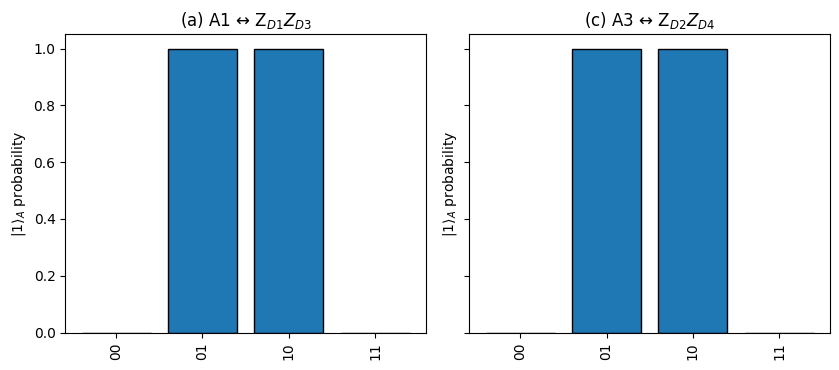

In [ ]:
# --- 실행 파라미터 ---
shots = 50_000
p1=0.0
p2 = 0.0
readout_flip = 0.0

# 좌 패널: A1 ↔ (D1,D3)
pA1, iA1, lA1 = p1_vs_pair([D1, D3], A1, shots=shots, p1=p1, p2=p2, readout_flip=readout_flip)

# 우 패널: A3 ↔ (D2,D4)
pA3, iA3, lA3 = p1_vs_pair([D2, D4], A3, shots=shots, p1=p1, p2=p2, readout_flip=readout_flip)

# --- 플로팅 (각 4개 막대) ---
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.8), sharey=True)

def panel(ax, probs, ideals, labels, title):
    x = np.arange(len(probs))
    ax.bar(x, probs, width=0.8)
    for xi, pid in zip(x, ideals):
        ax.add_patch(plt.Rectangle((xi-0.4, 0), 0.8, pid, fill=False))
    ax.set_xticks(x, labels, rotation=90)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(r"$|1\rangle_A$ probability")
    ax.set_title(title)

panel(axes[0], pA1, iA1, lA1, "(a) A1 ↔ Z$_{D1}Z_{D3}$")
panel(axes[1], pA3, iA3, lA3, "(c) A3 ↔ Z$_{D2}Z_{D4}$")

plt.tight_layout()
plt.show()

In [ ]:
subsetX, ancX = [D1,D2,D3,D4], A2

shots = 50_000
p1=0.0
p2 = 0.0
readout_flip = 0.0

pX, iX, lX = run_stabilizer(build_X_stabilizer, subsetX, ancX,
                            states, shots, p2, readout_flip)

# Plot (1개의 축만 생성)
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_panel(ax, pX, iX, lX, "(B) A2 ↔ $X_{D1}X_{D2}X_{D3}X_{D4}$")
plt.tight_layout()
plt.show()


TypeError: 'module' object is not iterable

In [ ]:
# --- 실행 파라미터 ---
shots = 50_000
p1 = 0.002
p2 = 0.03
readout_flip = 0.01

# 좌 패널: A1 ↔ (D1,D3)
pA1, iA1, lA1 = p1_vs_pair([D1, D3], A1, shots=shots, p1=p1, p2=p2, readout_flip=readout_flip)

# 우 패널: A3 ↔ (D2,D4)
pA3, iA3, lA3 = p1_vs_pair([D2, D4], A3, shots=shots, p1=p1, p2=p2, readout_flip=readout_flip)

# --- 플로팅 (각 4개 막대) ---
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.8), sharey=True)

def panel(ax, probs, ideals, labels, title):
    x = np.arange(len(probs))
    ax.bar(x, probs, width=0.8)
    for xi, pid in zip(x, ideals):
        ax.add_patch(plt.Rectangle((xi-0.4, 0), 0.8, pid, fill=False))
    ax.set_xticks(x, labels, rotation=90)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(r"$|1\rangle_A$ probability")
    ax.set_title(title)

panel(axes[0], pA1, iA1, lA1, "(a) A1 ↔ Z$_{D1}Z_{D3}$")
panel(axes[1], pA3, iA3, lA3, "(c) A3 ↔ Z$_{D2}Z_{D4}$")

plt.tight_layout()
plt.show()

# --- 각 막대의 데이터 출력 ---
print("\n=== A1 ↔ Z_D1 Z_D3 results ===")
for lbl, prob in zip(lA1, pA1):
    print(f"State {lbl} : P(|1⟩_A1) = {prob:.4f}")

print("\n=== A3 ↔ Z_D2 Z_D4 results ===")
for lbl, prob in zip(lA3, pA3):
    print(f"State {lbl} : P(|1⟩_A3) = {prob:.4f}")


In [ ]:
subsetX, ancX = [D1, D2, D3, D4], A2

shots = 50_000
p1 = 0.002
p2 = 0.03
readout_flip = 0.01

# Run
pX, iX, lX = run_stabilizer(build_X_stabilizer, subsetX, ancX,
                            states, shots, p2, readout_flip)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
plot_panel(ax, pX, iX, lX, "(B) A2 ↔ $X_{D1}X_{D2}X_{D3}X_{D4}$")
plt.tight_layout()
plt.show()

# --- 각 막대 데이터 출력 ---
print("\n=== A2 ↔ X_D1 X_D2 X_D3 X_D4 results ===")
for lbl, prob in zip(lX, pX):
    print(f"State {lbl} : P(|1⟩_A2) = {prob:.4f}")


# Repeated QEC

In [ ]:
# !pip install -q stim
import numpy as np
import itertools
import matplotlib.pyplot as plt
import stim

# Qubit indices
D1, D2, D3, D4, A1, A2, A3 = 0, 1, 2, 3, 4, 5, 6
DATA = [D1, D2, D3, D4]


In [ ]:
def prepare_logical_state(c: stim.Circuit, which: str):
    """
    which: '0L' or '1L'
    |0>_L = (|0000>+|1111>)/sqrt2  : H(D1); CNOT D1->D2,D3,D4
    |1>_L = X on (D2,D4) applied to |0>_L
    """
    # reset all to |0>
    for q in range(7):
        c.append_operation("R", [q])

    # |0>_L
    c.append_operation("H", [D1])
    for t in [D2, D3, D4]:
        c.append_operation("CX", [D1, t])

    if which == "1L":
        c.append_operation("X", [D2])
        c.append_operation("X", [D4])


In [ ]:
def append_X_stabilizer_cycle(c: stim.Circuit, p1=0.0, p2=0.0, readout_flip=0.0):
    """
    Measures X-parity of D1..D4 using ancilla A2.
    Sequence (Clifford-only):
      H on {D1..D4,A2}  → CNOT(A2->Di for i=1..4)  → H on {D1..D4,A2}  → M(A2)
    """
    # ancilla fresh
    c.append_operation("R", [A2])

    # basis change to map X parity -> Z
    for q in DATA + [A2]:
        c.append_operation("H", [q])
        if p1 > 0:
            c.append_operation("DEPOLARIZE1", [q], p1)

    # parity map
    for d in DATA:
        c.append_operation("CX", [A2, d])
        if p2 > 0:
            c.append_operation("DEPOLARIZE2", [A2, d], p2)

    # revert basis
    for q in DATA + [A2]:
        c.append_operation("H", [q])
        if p1 > 0:
            c.append_operation("DEPOLARIZE1", [q], p1)

    # readout error and measure
    if readout_flip > 0:
        c.append_operation("X_ERROR", [A2], readout_flip)
    c.append_operation("M", [A2])  # 1 bit for this cycle


In [ ]:
def append_Z_stabilizers_cycle(c: stim.Circuit, p2=0.0, readout_flip=0.0):
    """
    Measures Z-parities:
      A1 ↔ (D1,D3),  A3 ↔ (D2,D4)
    Sequence:
      R(A1,A3) → CNOT(D1->A1), CNOT(D3->A1), CNOT(D2->A3), CNOT(D4->A3) → M(A1,A3)
    """
    c.append_operation("R", [A1, A3])

    for d in [D1, D3]:
        c.append_operation("CX", [d, A1])
        if p2 > 0:
            c.append_operation("DEPOLARIZE2", [d, A1], p2)
    for d in [D2, D4]:
        c.append_operation("CX", [d, A3])
        if p2 > 0:
            c.append_operation("DEPOLARIZE2", [d, A3], p2)

    if readout_flip > 0:
        c.append_operation("X_ERROR", [A1], readout_flip)
        c.append_operation("X_ERROR", [A3], readout_flip)
    c.append_operation("M", [A1, A3])  # 2 bits for this cycle


In [ ]:
def build_full_circuit(logical="0L", cycles=5, p1=0.0, p2=0.0, readout_flip=0.0):
    """
    One 'cycle' = X-stabilizer (A2) → Z-stabilizers (A1,A3).
    Returns (circuit, bits_per_cycle=3).
    Ideal parity for |0>_L or |1>_L is 0 for all three ancillas.
    """
    c = stim.Circuit()
    prepare_logical_state(c, logical)

    for _ in range(cycles):
        append_X_stabilizer_cycle(c, p1=p1, p2=p2, readout_flip=readout_flip)
        append_Z_stabilizers_cycle(c, p2=p2, readout_flip=readout_flip)

    return c, 3

def success_prob_vs_cycle(logical="0L", cycles=10, shots=50_000, p1=0.0, p2=0.0, readout_flip=0.0):
    c, k = build_full_circuit(logical, cycles, p1, p2, readout_flip)
    smp = c.compile_sampler().sample(shots)        # shape: (shots, cycles*k)
    # Ideal outcomes (for both |0>_L and |1>_L): A2=0, A1=0, A3=0 each cycle
    ok = np.ones(cycles, dtype=float)
    for r in range(cycles):
        # columns for this cycle: [A2, A1, A3]
        cols = slice(r*k, r*k + k)
        # success = all three zeros
        good = (smp[:, cols].sum(axis=1) == 0)
        ok[r] = good.mean()
    return ok


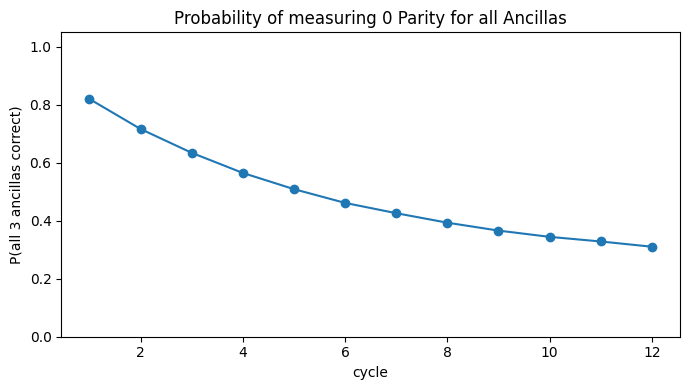

In [ ]:
# ---- Params ----
logical = "0L"     # '0L' or '1L'
cycles  = 12
shots   = 50_000
p1 = 0.002         # 1Q depolarizing after each H (X-stab only)
p2 = 0.03          # 2Q depolarizing after each CNOT
readout_flip = 0.01

# ---- Run ----
probs = success_prob_vs_cycle(logical=logical, cycles=cycles, shots=shots,
                              p1=p1, p2=p2, readout_flip=readout_flip)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.arange(1, cycles+1), probs, marker="o")
ax.set_xlabel("cycle")
ax.set_ylabel("P(all 3 ancillas correct)")
ax.set_ylim(0, 1.05)
ax.set_title(f"Probability of measuring 0 Parity for all Ancillas")
plt.tight_layout()
plt.show()


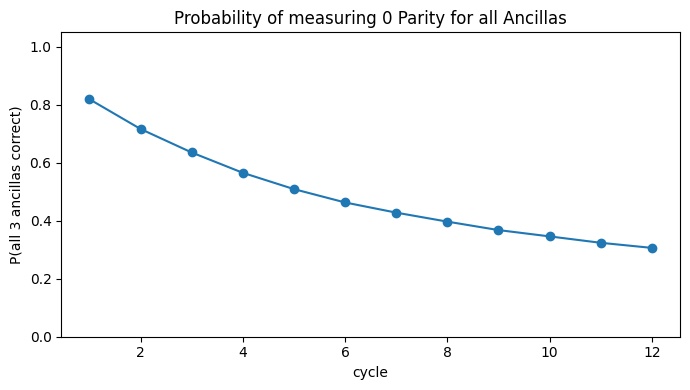

In [ ]:
# ---- Params ----
logical = "1L"     # '0L' or '1L'
cycles  = 12
shots   = 50_000
p1 = 0.002         # 1Q depolarizing after each H (X-stab only)
p2 = 0.03          # 2Q depolarizing after each CNOT
readout_flip = 0.01

# ---- Run ----
probs = success_prob_vs_cycle(logical=logical, cycles=cycles, shots=shots,
                              p1=p1, p2=p2, readout_flip=readout_flip)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.arange(1, cycles+1), probs, marker="o")
ax.set_xlabel("cycle")
ax.set_ylabel("P(all 3 ancillas correct)")
ax.set_ylim(0, 1.05)
ax.set_title(f"Probability of measuring 0 Parity for all Ancillas")
plt.tight_layout()
plt.show()
